### Task 1 

Implement Harris corner detector from scratch. Mark detected corners on original image. 

Your program is supposed to detect the corners in the middle part of the image and not the weak corners at the boundary of the image.

Note: You shouldn't use cv2.cornerHarris() or any other library functions to detect the corners.

<img src = Images/checkerboard.jpg>

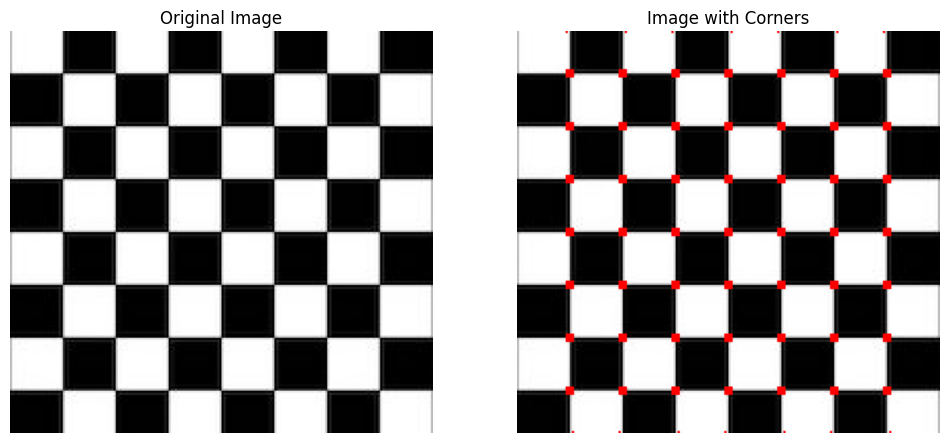

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def detect_corners(img, block_size, ksize, k):
    """Detects corners using the Harris corner detection algorithm."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)

    # Sobel gradients
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)

    # Harris Corner Response Calculation
    sobel_xx = cv2.GaussianBlur(sobel_x ** 2, (block_size, block_size), 0)
    sobel_yy = cv2.GaussianBlur(sobel_y ** 2, (block_size, block_size), 0)
    sobel_xy = cv2.GaussianBlur(sobel_x * sobel_y, (block_size, block_size), 0)

    determinant = sobel_xx * sobel_yy - sobel_xy ** 2
    trace = sobel_xx + sobel_yy

    harris_response = determinant - k * trace ** 2

    # Thresholding to get corner points
    threshold = 0.01 * harris_response.max()
    corner_img = np.zeros_like(gray)
    corner_img[harris_response > threshold] = 255

    # Find coordinates of corners
    corners = np.argwhere(corner_img == 255)

    return corners

def mark_corners(img, corners):
    img_copy = np.copy(img)
    for corner in corners:
        # Highlight corners in red by drawing a small filled circle
        y, x = corner
        x = max(0, min(img.shape[0] - 1, x-5))
        y = max(0, min(img.shape[1] - 1, y+5))
        img_copy[x, y] = [0, 0, 255]
    return img_copy

def display_images(original, processed, original_title="Original Image", processed_title="Image with Corners"):
    """Displays the original and processed images side by side."""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title(original_title)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
    plt.title(processed_title)
    plt.axis('off')

    plt.show()

def main():
    # Load the input image
    checkerboard = cv2.imread('./Images/checkerboard.jpg')

    # Detect corners using the Harris corner detection algorithm
    response_matrix = detect_corners(checkerboard, block_size=3, ksize=3, k=0.04)

    # Mark the detected corners on the input image
    image_with_corners = mark_corners(checkerboard, response_matrix)
    
    # Resize the output image to match the size of the original image
    resized_marked_image = cv2.resize(image_with_corners, (checkerboard.shape[1], checkerboard.shape[0]))

    # Display the original and the corner-marked images side by side
    display_images(checkerboard, resized_marked_image)

# Execute the main function
if __name__ == "__main__":
    main()


### Task 2 

Implement multiscale template matching that measures the SSD differences (perform both brightness and contrast normalization) between the template and each location of the image at multiple scales. Both image and template are grayscale images. 

For this task, consider a linear range of scales, np.arange( 0.5, 3, .25). 

Show your best match for each size(0.5, 0.75, 1 etc.) in a 2X5 plot. 

Template: <img src = Images/template.png>

Test Image: <img src = Images/test_image.png style="width:537px; height:400px">


Note: 
1. You should implement template matching from scratch, and not use the opencv template matching.
2. Only use "bilinear interpolation" when resizing.

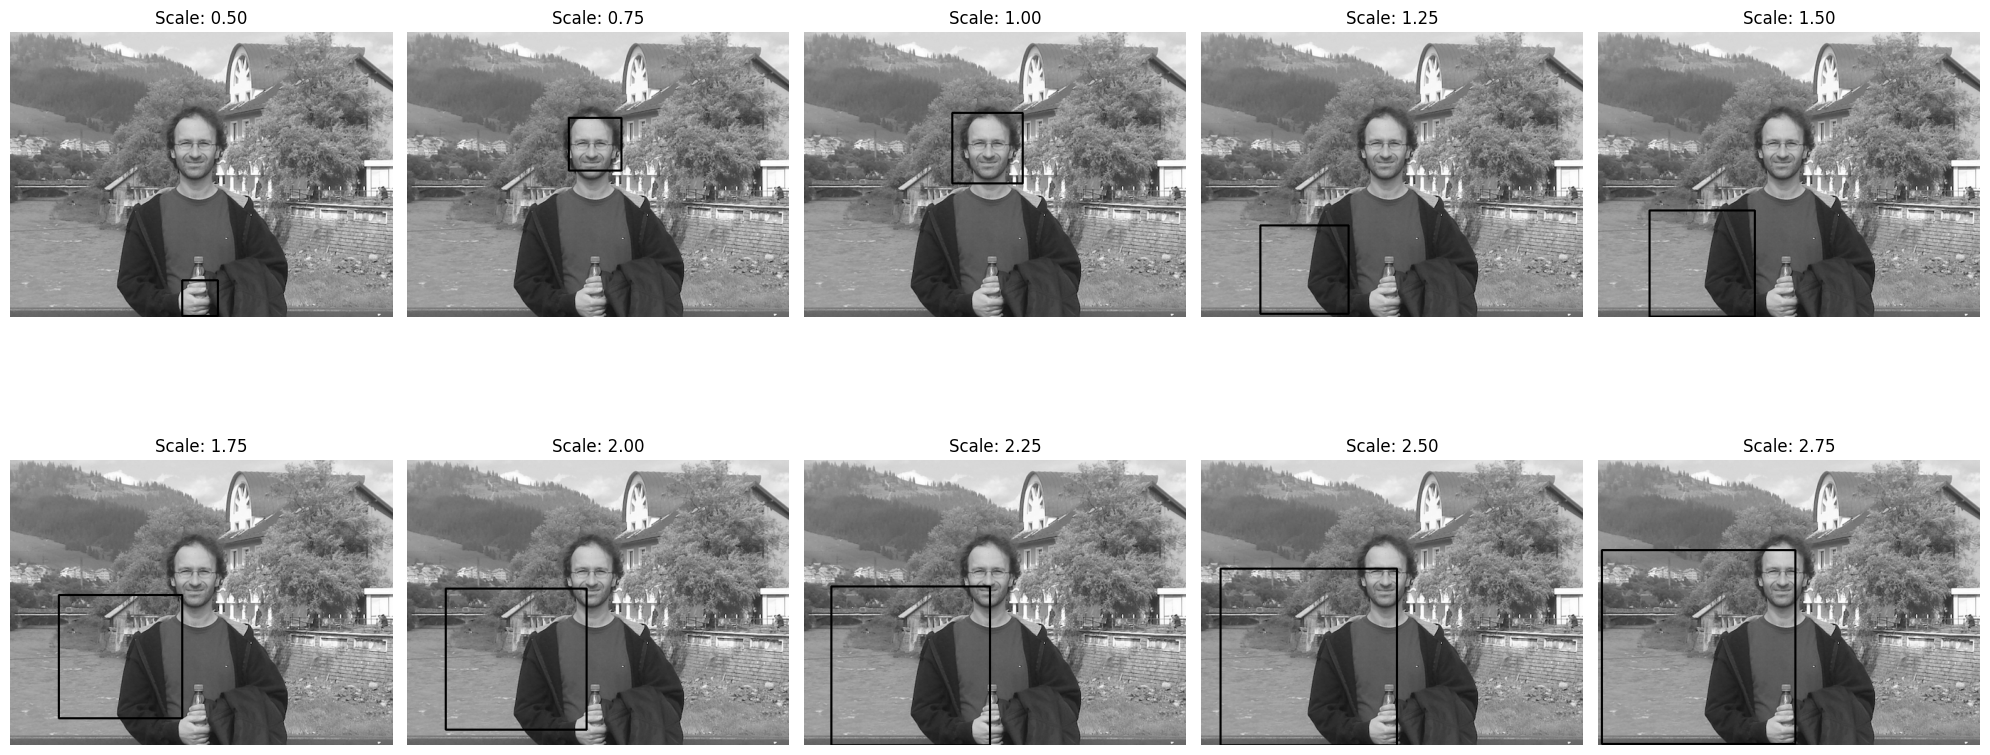

In [73]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

def load_and_convert_image(path):
    """Load an image and convert it to grayscale."""
    image = cv2.imread(path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def normalize_image(image):
    """Normalize the image by subtracting the mean and dividing by the standard deviation."""
    return (image - np.mean(image)) / np.std(image)

def resize_template_or_image(template, image, scale):
    """Resize the template or image based on the scale factor."""
    if scale <= 1:
        resized_template = cv2.resize(template, dsize=None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
        resized_image = image
    else:
        resized_template = template
        resized_image = cv2.resize(image, dsize=None, fx=(1 / scale), fy=(1 / scale), interpolation=cv2.INTER_LINEAR)
    return resized_template, resized_image

def compute_ssd(normalized_template, normalized_window):
    """Compute the Sum of Squared Differences (SSD) between the template and window."""
    return np.sum((normalized_window - normalized_template) ** 2)

def find_best_match_location(image, template):
    """Find the location in the image with the lowest SSD for the given template."""
    template_height, template_width = template.shape
    image_height, image_width = image.shape

    min_ssd = math.inf
    best_location = None

    for row in range(image_height - template_height + 1):
        for col in range(image_width - template_width + 1):
            image_window = image[row:row + template_height, col:col + template_width]
            normalized_window = normalize_image(image_window)
            ssd_score = compute_ssd(template, normalized_window)
            
            if ssd_score < min_ssd:
                min_ssd = ssd_score
                best_location = (row, col)

    return best_location, min_ssd

def adjust_coordinates_for_scale(location, template_shape, scale):
    """Adjust coordinates back to the original scale if the image was downscaled."""
    top_left_y, top_left_x = location
    template_height, template_width = template_shape
    bottom_right_y = top_left_y + template_height
    bottom_right_x = top_left_x + template_width

    if scale > 1:
        top_left_y = int(top_left_y * scale)
        bottom_right_y = int(bottom_right_y * scale)
        top_left_x = int(top_left_x * scale)
        bottom_right_x = int(bottom_right_x * scale)

    return (top_left_x, top_left_y), (bottom_right_x, bottom_right_y)

def draw_rectangle(image, top_left, bottom_right):
    """Draw a rectangle on the image from top left to bottom right coordinates."""
    annotated_image = image.copy()
    return cv2.rectangle(annotated_image, top_left, bottom_right, (0, 255, 0), 2)

def perform_multiscale_template_matching(test_image, template_image, scales):
    """Perform template matching at multiple scales and return the best match per scale."""
    matches_per_scale = []
    for scale_factor in scales:
        resized_template, resized_image = resize_template_or_image(template_image, test_image, scale_factor)
        normalized_template = normalize_image(resized_template)
        best_location, _ = find_best_match_location(resized_image, normalized_template)
        top_left, bottom_right = adjust_coordinates_for_scale(best_location, resized_template.shape, scale_factor)
        annotated_image = draw_rectangle(test_image, top_left, bottom_right)
        matches_per_scale.append((scale_factor, annotated_image))
    return matches_per_scale

def plot_matches(matches_per_scale):
    """Plot the matched regions for each scale in a 2x5 grid."""
    plt.figure(figsize=(20, 10))
    for index, (scale, annotated_img) in enumerate(matches_per_scale, 1):
        plt.subplot(2, 5, index)
        plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        plt.title(f'Scale: {scale:.2f}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Main code execution
test_image_path = './Images/test_image.png'
template_image_path = './Images/template.png'
scale_range = np.arange(0.5, 3, 0.25)

# Load and preprocess images
test_image_gray = load_and_convert_image(test_image_path)
template_gray = load_and_convert_image(template_image_path)

# Perform multiscale template matching
matches = perform_multiscale_template_matching(test_image_gray, template_gray, scale_range)

# Plot results
plot_matches(matches)


## Task 3: Eigenfaces 

### Task 3A 
1. Load all the 25 images in the "/Eigenfaces/Train"
2. Display all the original faces in a 5X5 grid.
3. Find the mean face image. Perform PCA on the training faces.
4. Display the mean face.
5. Diplay all the eigenfaces in a 5X5 grid.

### Task 3B 

1. Select k = 3 eigenfaces (eigenvectors that correspond to the largest eigenvalues).
2. Reconstruct the training faces and display the reconstructed faces in a 5X5 grid.
3. Repeat the process for k = 7 and k = 15. For each k, reconstruct the training faces and display the reconstructed image in a 5X5 grid.


### Task 3C 
1. Load all the test images from "/Eigenfaces/Test"
2. Project each test image on the k = 3 eigenvectors and find if it's a face. If it's a face, find it's closest training image. Use euclidean distance to calculate distance.
3. Display all the results in an M X 2 table, where M is total no of test images. Each row of the table displays two images. The image on the left is the test image. The image on the right is it's closest image in the eigenfaces space (Display the closest Training Image) . If an image is classified as a non-face, then the second column in the table should be blank (Just display a black image).
4. Repeat the process and display the results for k = 7, k = 15.


### Task 3D  
Plot the percent classification error rate as a function of Number of Eigenfaces (k). k should range from 1 to N (where N is the number of images in the training set). The steps are desribed below:

1. Project k on Training images
2. For each projection reconstruct the image
3. Look for the closest image in the Training image based on the reconstructed image , and assign it a class label ( the class label is imagename[2:4] in a imagename.jpg for example here, S034_005_02293928.jpg the class label is 34)
4. Count all the mismatches based on the ground truths (use the class label from the image name, and the one assigned previously based on the reconstructed image).
5. For each k calculate error_rate = mismatches / len(train_images) 

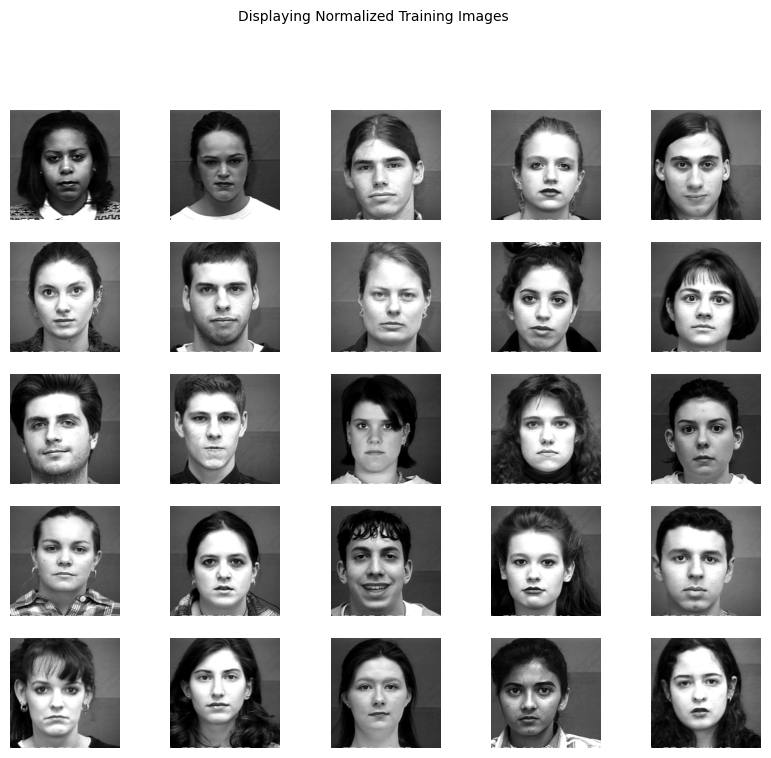

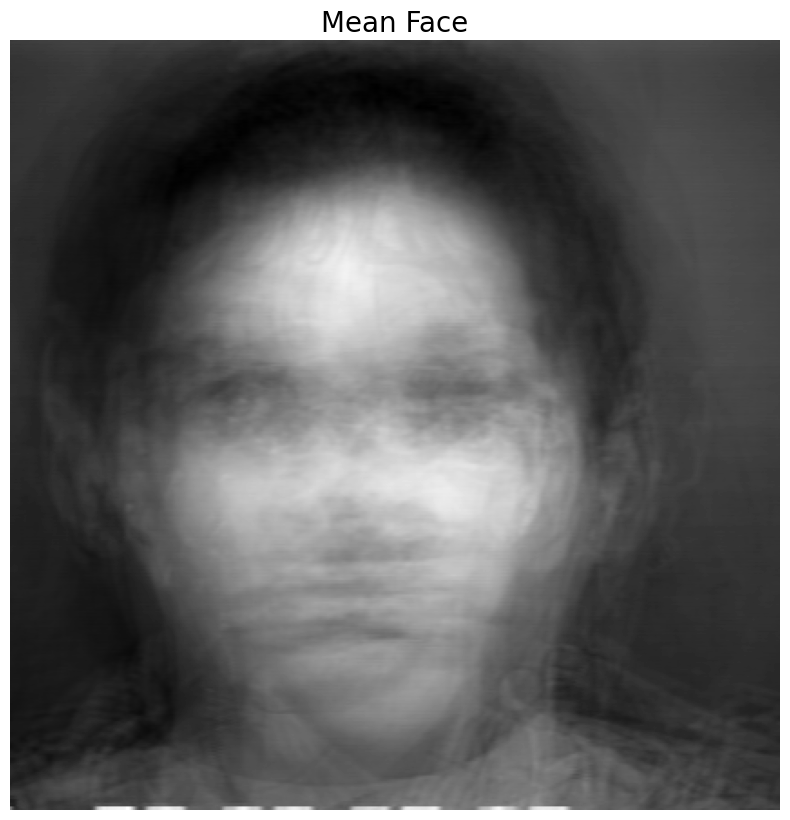

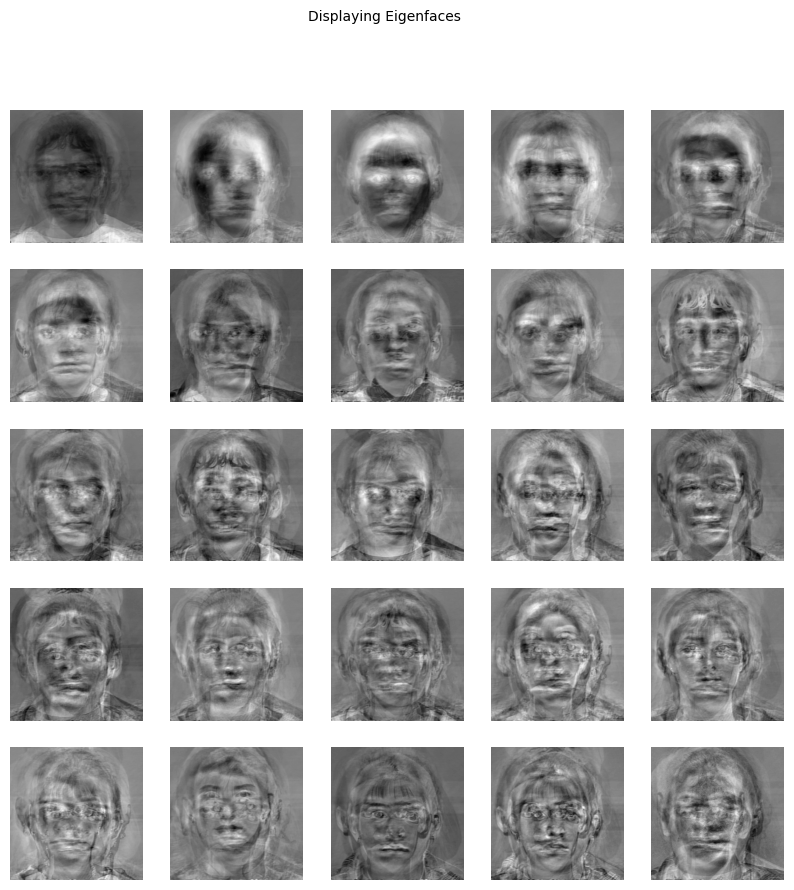

In [74]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Directory path and global constants
TRAIN_IMAGES_DIR = './Eigenfaces/Train'

def display_images(images, title="Images", columns=5, figsize=(10, 10)):
    """Display a set of images with titles."""
    plt.figure(figsize=figsize)
    for idx, (name, img) in enumerate(images.items()):
        plt.subplot(len(images) // columns + 1, columns, idx + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(title, fontsize=10)
    plt.show()

def load_and_normalize_images(directory):
    """Load and normalize images from the specified directory."""
    images = {}
    for file_name in os.listdir(directory):
        image = cv2.imread(f'{directory}/{file_name}')
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Normalize the image
        mean_gray = np.mean(image_gray)
        std_dev_gray = np.std(image_gray)
        normalized_image = (image_gray - mean_gray) / std_dev_gray
        images[file_name] = normalized_image
    return images

def compute_mean_face(images):
    """Compute the mean face from a dictionary of images."""
    mean_face = None
    for i, img in enumerate(images.values()):
        if i == 0:
            mean_face = np.copy(img)
        else:
            mean_face += img
    mean_face /= len(images)
    return mean_face

def create_stacked_matrix(images, mean_face):
    """Create a stacked matrix of centered images for PCA."""
    stacked_matrix = []
    for img in images.values():
        centered_img = img - mean_face
        stacked_matrix.append(centered_img.flatten())
    return np.array(stacked_matrix)

def compute_eigenfaces(stacked_matrix, num_eigenfaces=25):
    """Compute eigenfaces using PCA on the stacked image matrix."""
    cov_matrix = np.dot(stacked_matrix, stacked_matrix.T) / (stacked_matrix.shape[1] - 1)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # Sort eigenvalues and corresponding eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Calculate eigenfaces
    eigenfaces = np.dot(stacked_matrix.T, sorted_eigenvectors)
    eigenfaces /= np.linalg.norm(eigenfaces, axis=0)
    return eigenfaces[:, :num_eigenfaces]

# Load images and compute eigenfaces
loaded_train_images = load_and_normalize_images(TRAIN_IMAGES_DIR)
average_image = compute_mean_face(loaded_train_images)
stacked_matrix = create_stacked_matrix(loaded_train_images, average_image)
eigenfaces = compute_eigenfaces(stacked_matrix)

# Display all the normalized training image
display_images(loaded_train_images, title="Displaying Normalized Training Images")

# Display the average image (mean face)
plt.figure(figsize=(10, 10))
plt.imshow(average_image, cmap='gray')
plt.title("Mean Face", fontsize=20)
plt.axis('off')
plt.show()

# Display first 25 eigenfaces
plt.figure(figsize=(10, 10))
for i in range(25):
    eigenface = eigenfaces[:, i].real
    height, width = average_image.shape
    eigenface_image = eigenface.reshape((height, width))
    
    plt.subplot(5, 5, i + 1)
    plt.imshow(eigenface_image, cmap='gray')
    plt.axis('off')
plt.suptitle("Displaying Eigenfaces", fontsize=10)
plt.show()


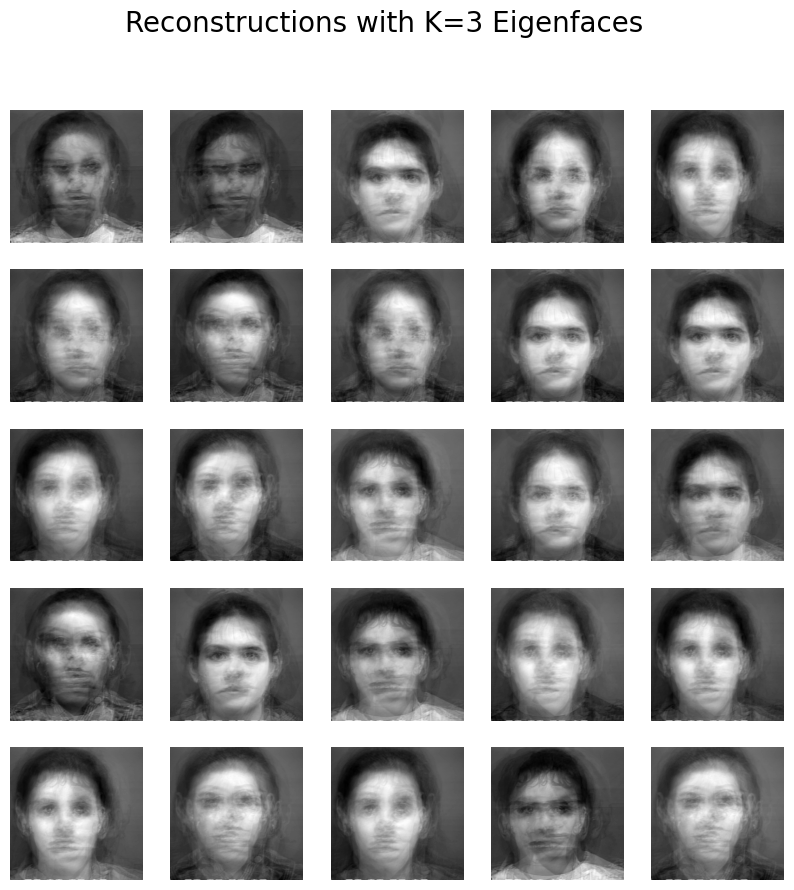

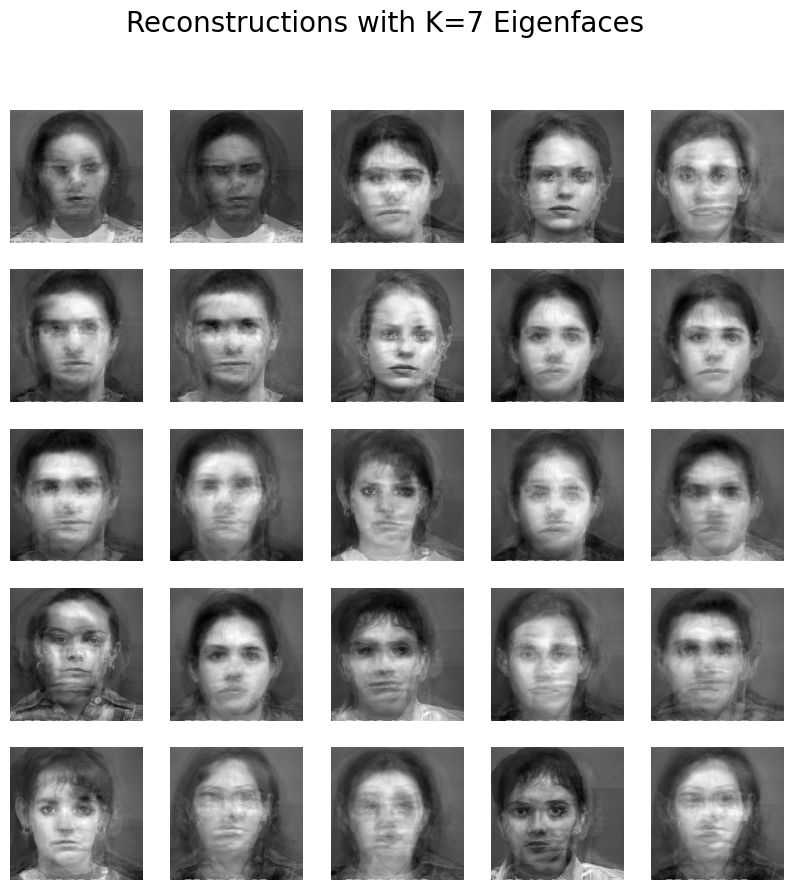

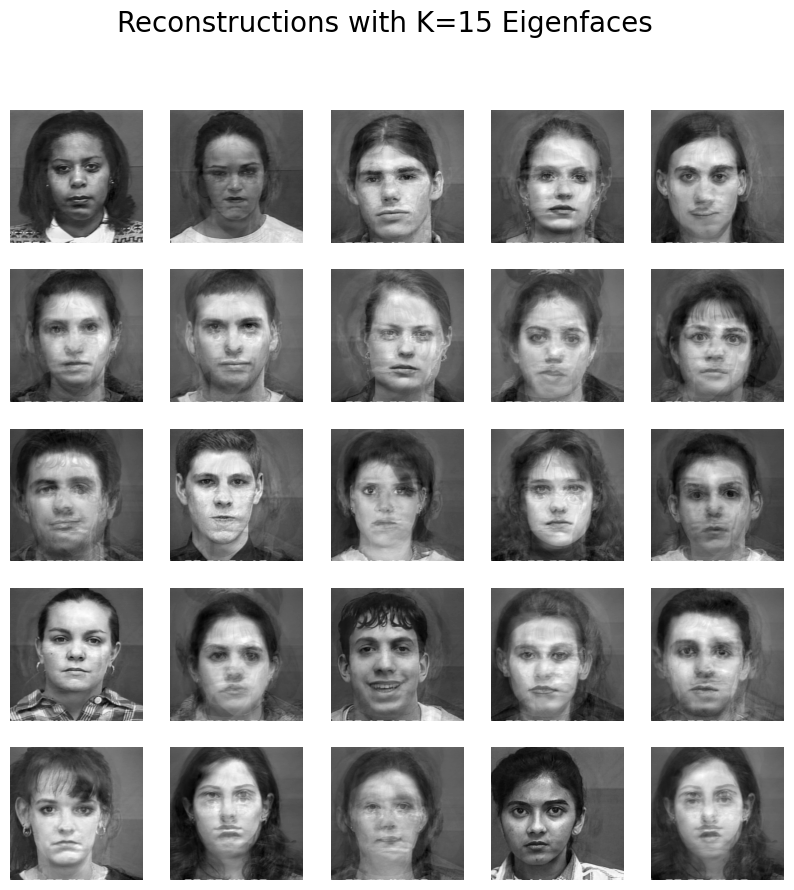

In [75]:
K_VALUES = [3, 7, 15]

def project_and_reconstruct_images(loaded_images, mean_face, eigenfaces, k, figsize=(10, 10)):
    """Project images onto the top K eigenfaces and reconstruct them."""
    eigenfaces_k = eigenfaces[:, :k].real  # Select the top K eigenfaces
    projections = []
    
    plt.figure(figsize=figsize)
    for idx, (name, img) in enumerate(loaded_images.items()):
        original_height, original_width = mean_face.shape
        centered_image = img - mean_face
        image_projection = np.dot(eigenfaces_k.T, centered_image.flatten())
        projections.append(image_projection)

        reconstructed_image = reconstruct_image(mean_face, eigenfaces_k, image_projection)
        display_reconstructed_image(reconstructed_image, original_height, original_width, idx)
        
    plt.suptitle(f'Reconstructions with K={k} Eigenfaces', fontsize=20)
    plt.show()
    
    return projections

def reconstruct_image(mean_face, eigenfaces_k, image_projection):
    """Reconstruct an image using mean face and projection onto top K eigenfaces."""
    mean_face_flattened = mean_face.flatten()
    projected_eigen = np.dot(eigenfaces_k, image_projection.reshape(-1, 1))
    reconstructed_flattened = mean_face_flattened[:, np.newaxis] + projected_eigen
    return reconstructed_flattened

def display_reconstructed_image(reconstructed_image, height, width, index):
    """Display a single reconstructed image in grayscale."""
    reconstructed_image_reshaped = reconstructed_image.reshape(height, width)
    plt.subplot(5, 5, index + 1)
    plt.imshow(reconstructed_image_reshaped, cmap='gray')
    plt.axis('off')

# Run projections and display reconstructed images for each K
for k in K_VALUES:
    project_and_reconstruct_images(loaded_train_images, average_image, eigenfaces, k)


In [76]:
#Helper cell to store reconstructed values 

K_VALUES = [3, 7, 15]

def project_training_images(loaded_images, mean_face, eigenfaces, k):
    """Project training images onto the top K eigenfaces."""
    eigenfaces_k = eigenfaces[:, :k].real
    projections = []
    
    for img in loaded_images.values():
        centered_image = img - mean_face
        image_projection = np.dot(eigenfaces_k.T, centered_image.flatten())
        projections.append(image_projection)
    
    return projections

# Project training images for each K value and store the projections
reconstruct3 = project_training_images(loaded_train_images, average_image, eigenfaces, 3)
reconstruct7 = project_training_images(loaded_train_images, average_image, eigenfaces, 7)
reconstruct15 = project_training_images(loaded_train_images, average_image, eigenfaces, 15)

# Convert projections to NumPy arrays for Part C
Np3 = np.array(reconstruct3)
Np7 = np.array(reconstruct7)
Np15 = np.array(reconstruct15)

# Prepare training images list for Part C
trainImgs = list(loaded_train_images.values())


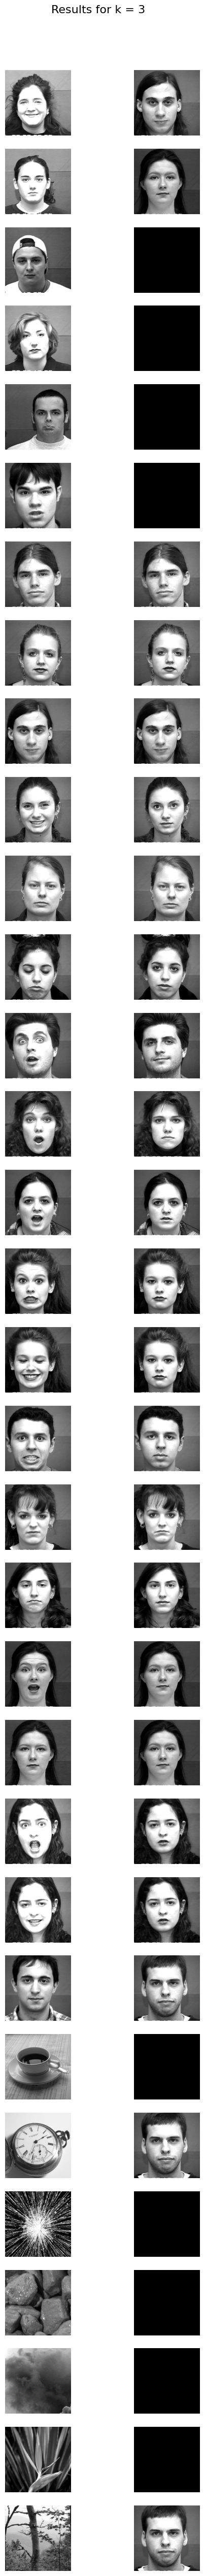

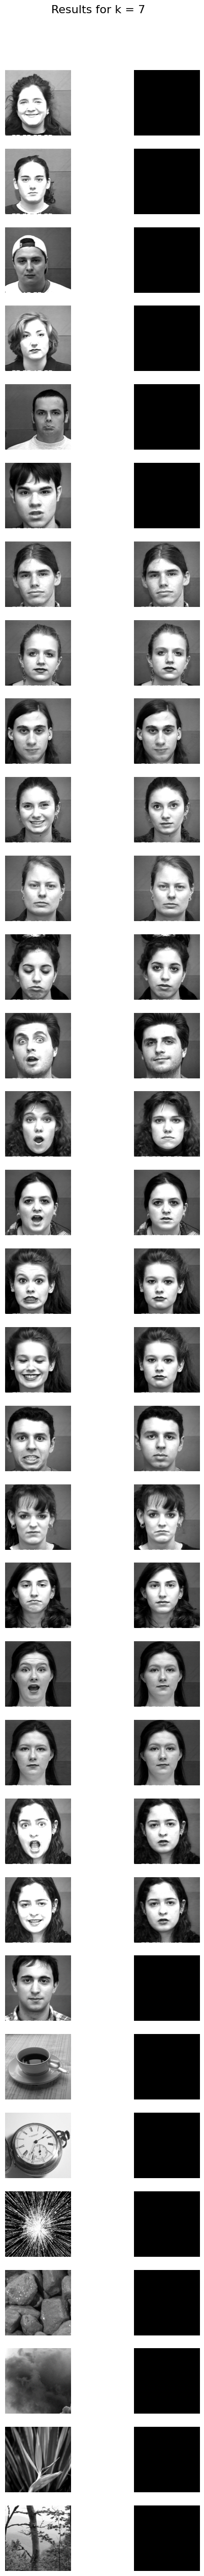

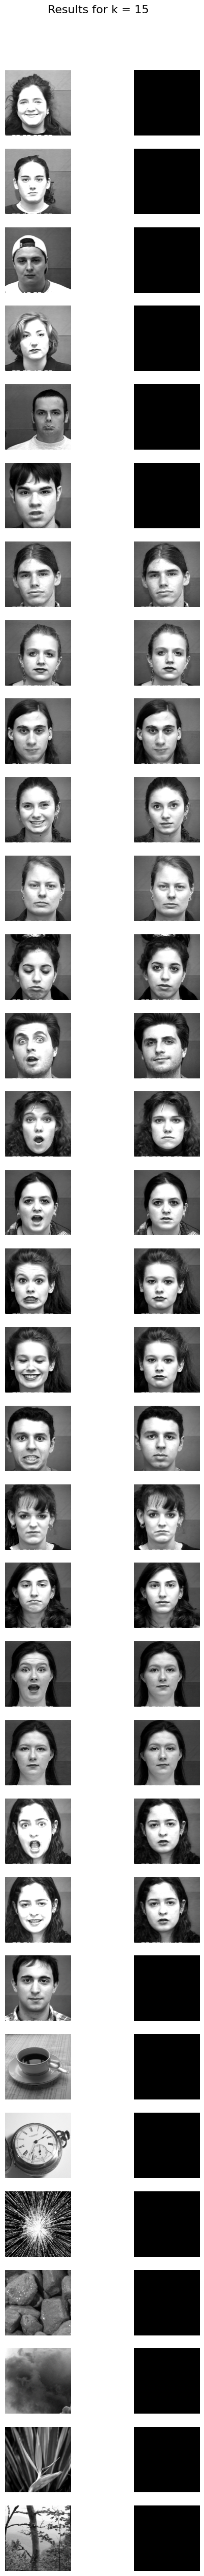

In [77]:
#Task 3C
import cv2
import numpy as np
import os
import math
import matplotlib.pyplot as plt

def find_closest_image(test_image, test_image_proj, train_image_projs, train_images, threshold):
    """Find the closest image in the training set to the test image projection."""
    min_dist = math.inf
    min_index = None
    for idx, train_image_proj in enumerate(train_image_projs):
        dist = np.linalg.norm(test_image_proj - train_image_proj)
        if dist < min_dist and dist < threshold:
            min_dist = dist
            min_index = idx

    if min_index is not None:
        return train_images[min_index]
    else:
        # Return a blank image if no close match is found
        return np.zeros_like(test_image)

def project_test_images(test_images_dir, eigenfaces, mean_image, k_values):
    """Project grayscale test images onto eigenfaces for multiple k values."""
    loaded_test_images = {}
    projections = {k: [] for k in k_values}
    
    for test_filename in os.listdir(test_images_dir):
        if test_filename.startswith("S0"):
            # Read test image in grayscale
            test_image = cv2.imread(os.path.join(test_images_dir, test_filename), cv2.IMREAD_GRAYSCALE)

            # Normalize
            normalized_test_image = (test_image - np.mean(test_image)) / np.std(test_image)

            # Center the test image
            test_image_centered = normalized_test_image - mean_image
            loaded_test_images[test_filename] = normalized_test_image

            # Project onto eigenfaces for each K
            for k in k_values:
                eigenfaces_k = eigenfaces[:, :k]
                test_image_proj = np.dot(eigenfaces_k.T, test_image_centered.flatten())
                projections[k].append((test_image, test_image_proj))
    
    return loaded_test_images, projections


def evaluate_projections(projections, train_image_projs, train_images, thresholds, k_values):
    """Evaluate projections for each K by finding the closest image for each test image."""
    results = {k: [] for k in k_values}
    
    for k in k_values:
        for test_image, test_image_proj in projections[k]:
            closest_image = find_closest_image(
                test_image, test_image_proj, train_image_projs[k], train_images, thresholds[k]
            )
            results[k].append((test_image, closest_image))
    
    return results

def display_results(results, k_values):
    """Display the test images and their closest matches for each K."""
    for k in k_values:
        plt.figure(figsize=(6, len(results[k]) * 2))
        for i, (test_image, closest_image) in enumerate(results[k]):
            plt.subplot(len(results[k]), 2, i * 2 + 1)
            plt.imshow(test_image, cmap='gray')
            plt.axis('off')

            plt.subplot(len(results[k]), 2, i * 2 + 2)
            plt.imshow(closest_image, cmap='gray')
            plt.axis('off')

        plt.suptitle(f'Results for k = {k}', fontsize=16, y=0.9)
        plt.show()

# Set up for Part C
test_images_dir = './Eigenfaces/Test'
thresholds = {3: 75, 7: 90, 15: 110}
k_values = [3, 7, 15]

# Assuming train_image_projs (3, 7, and 15), train_images, average_image, and eigenfaces are defined in Part A and Part B
loaded_test_images, projections = project_test_images(test_images_dir, eigenfaces, average_image, k_values)
train_image_projs = {3: np.array(Np3), 7: np.array(Np7), 15: np.array(Np15)}

# Find closest images for each k
results = evaluate_projections(projections, train_image_projs, trainImgs, thresholds, k_values)

# Display the results
display_results(results, k_values)


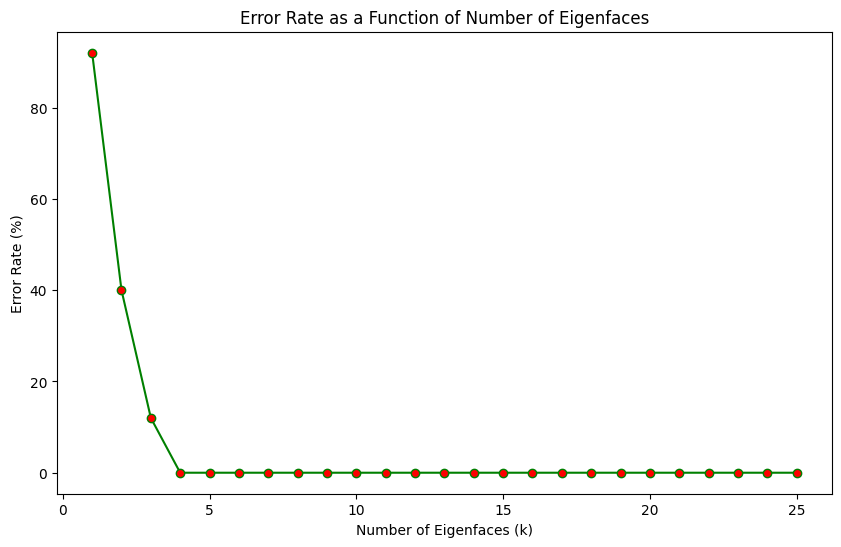

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import math

def find_closest_train_image(test_projection, train_projections, train_labels):
    """Find the closest training image label to the test image projection."""
    min_dist = math.inf
    min_index = None
    for idx, train_projection in enumerate(train_projections):
        dist = np.linalg.norm(test_projection - train_projection)
        if dist < min_dist:
            min_dist = dist
            min_index = idx
    
    # Return the class label of the closest image if found
    if min_index is not None:
        return train_labels[min_index][2:4]
    return None

def calculate_error_rate(k, eigenfaces, mean_face, train_images, train_labels):
    """Calculate the classification error rate using the top K eigenfaces."""
    top_k_eigenfaces = eigenfaces[:, :k].real
    train_projections = []

    # Project all training images using the top K eigenfaces
    for _, train_img in train_images.items():
        centered_img = train_img - mean_face
        projection = np.dot(top_k_eigenfaces.T, centered_img.flatten())
        train_projections.append(projection)
    
    train_projections_np = np.array(train_projections)
    mismatches = 0

    # Test each training image projection
    for img_name, train_img in train_images.items():
        actual_label = img_name[2:4]
        
        # Project the image
        centered_img = train_img - mean_face
        img_projection = np.dot(top_k_eigenfaces.T, centered_img.flatten())
        
        # Reconstruct the image using the top K eigenfaces
        reconstructed_flat = mean_face.flatten()[:, np.newaxis] + np.dot(top_k_eigenfaces, img_projection.reshape(-1, 1))
        reconstructed_img = reconstructed_flat.reshape(mean_face.shape)
        
        # Normalize reconstructed image
        normalized_reconstructed_img = (reconstructed_img - np.mean(reconstructed_img)) / np.std(reconstructed_img)
        
        # Project the normalized reconstructed image
        reconstructed_img_centered = normalized_reconstructed_img - mean_face
        reconstructed_img_projection = np.dot(top_k_eigenfaces.T, reconstructed_img_centered.flatten())
        
        # Find the closest training image based on the reconstructed projection
        predicted_label = find_closest_train_image(reconstructed_img_projection, train_projections_np, list(train_images.keys()))
        
        # Count mismatches
        if predicted_label != actual_label:
            mismatches += 1

    total_images = len(train_images)
    error_rate = mismatches / total_images

    return error_rate

def plot_error_rate_vs_k(train_images, eigenfaces, mean_face):
    """Calculate and plot the error rate as a function of the number of eigenfaces (K)."""
    num_images = len(train_images)
    k_values = list(range(1, num_images + 1))
    error_rates = [calculate_error_rate(k, eigenfaces, mean_face, train_images, list(train_images.keys())) for k in k_values]

    # Plotting with green line and red markers
    plt.figure(figsize=(10, 6))
    plt.plot(
        k_values, 
        [rate * 100 for rate in error_rates], 
        marker='o', 
        linestyle='-', 
        color='g',           # Green line
        markerfacecolor='r',  # Red markers
        label='Error Rate (%)'
    )
    plt.xlabel('Number of Eigenfaces (k)')
    plt.ylabel('Error Rate (%)')
    plt.title('Error Rate as a Function of Number of Eigenfaces')
    plt.show()

# Assuming loaded_train_images, average_image, and eigenfaces are available from previous parts
plot_error_rate_vs_k(loaded_train_images, eigenfaces, average_image)
